
# News Aggregator Zoha Karimzadeh

In this task, we are building a news aggregator in Python that goes beyond simple web scraping by incorporating 
Machine Learning (ML) functionality like topic modeling, sentiment analysis, emotional analysis, and political bias detection.
The solution includes the following key features:

1. **Web Scraping**: Scraping articles from news websites using BeautifulSoup and Newspaper3k.
2. **Text Preprocessing**: Stopword removal, and tokenization using spaCy and nltk.
3. **Topic Modeling**: Extracting underlying topics using Latent Dirichlet Allocation (LDA) with sklearn.
4. **Sentiment Analysis**: Determining the sentiment (positive, negative, neutral) of articles using a pre-trained transformer model with transformers.
5. **Emotion Analysis**: Detecting emotions in the articles, such as joy, sadness, anger, etc with transformers.
6. **Political Bias Detection**: Dummy labels to showcase classification, with Logistic Regression for bias prediction.
7. **Data Visualization**: Presenting results such as sentiment distribution and emotion analysis with Matplotlib and Seaborn.

The goal is to scrape news articles, preprocess the text, and apply ML models to gain insights into the sentiment, emotions, 
and potential political bias in the articles.



## Step 1: Importing Libraries and Initial Setup

We begin by importing necessary libraries. 
Then download NLTK Data and Load spaCy language Model to handle text processing tasks like tokenization.
We also set log level and warning settings to prevent showing unnecessary warnings.


In [16]:

import pandas as pd
from newspaper import Article
import nltk
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline
import spacy
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

warnings.filterwarnings("ignore")

# Suppress transformers library warnings
logging.getLogger('transformers').setLevel(logging.ERROR)

# Suppress nltk download messages
logging.getLogger('nltk').setLevel(logging.ERROR)

# Ensure required NLTK datasets are available
nltk.download('punkt', quiet=True)

# Load spaCy model for text preprocessing
nlp = spacy.load('en_core_web_sm')



## Step 2: Fetching Articles

We define a function `fetch_articles` that takes a list of URLs, scrapes articles from those URLs, and returns the data in a 
Pandas DataFrame. The Newspaper3k library is used to extract article content, while BeautifulSoup helps to find article links.

This is the starting point of the news aggregation process.


In [2]:

# Define URLs for web scraping
urls = [
    'https://www.bbc.com/news/world',
    'https://www.cnn.com/world',
    'https://www.aljazeera.com/news/',
]

def fetch_articles(urls):
    """Fetches articles from the given URLs and returns a DataFrame."""
    articles = []
    for url in urls:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        for link in soup.find_all('a', href=True):
            if 'https' in link['href']:
                try:
                    article = Article(link['href'])
                    article.download()
                    article.parse()
                    articles.append({
                        'title': article.title,
                        'text': article.text,
                        'url': link['href']
                    })
                except Exception as e:
                    print(f"Error fetching article: {e}")
    return pd.DataFrame(articles)

# Fetch articles and convert to DataFrame
df = fetch_articles(urls)
df.head()


,title,text,url
0,BBC Sounds - Music. Radio. Podcasts,LIVE · 20:00 - 20:45\n\nToday\n\nAfter the Gre...,https://www.bbc.co.uk/sounds
1,BBC Weather,"Autumn 2024: When does it start, and what is t...",https://www.bbc.com/weather
2,BBC Newsletters,,https://www.bbc.com/newsletters
3,"Breaking News, World News, US News, Sports, Bu...",I heard years of Grenfell testimony. Here's wh...,https://www.bbc.com/
4,BBC Sounds - Music. Radio. Podcasts,LIVE · 20:00 - 20:45\n\nToday\n\nAfter the Gre...,https://www.bbc.co.uk/sounds



## Step 3: Data Preprocessing

We define a function `preprocess` that uses spaCy to clean and preprocess the text. The function converting words to their base form and removes stopwords.

This step ensures that the text is in a suitable format for topic modeling and other analyses.


In [3]:

# Data Preprocessing
def preprocess(text):
    """Preprocesses text data using spaCy for lemmatization and stopword removal."""
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['text'].apply(preprocess)
df[['title', 'processed_text']].head()


,title,processed_text
0,BBC Sounds - Music. Radio. Podcasts,live today grenfell inquiry deliver safe secur...
1,BBC Weather,autumn start equinox autumn begin year autumn ...
2,BBC Newsletters,
3,"Breaking News, World News, US News, Sports, Bu...",hear year grenfell testimony disaster prevent ...
4,BBC Sounds - Music. Radio. Podcasts,live today grenfell inquiry deliver safe secur...



## Step 4: Topic Modeling Using Latent Dirichlet Allocation (LDA)

We use LDA for topic modeling to discover abstract topics within the articles. The `CountVectorizer` converts the text into a 
vectorized format, and then we fit the LDA model to uncover different topics.

We also define a `display_topics` function to show the top words in each topic.


In [4]:

# Topic Modeling Using LDA
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

def display_topics(model, feature_names, n_top_words):
    """Displays the top words for each topic in LDA model."""
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)


Topic 0:
cnn hospital al min gaza say president harris trump political
Topic 1:
password life account new reset jazeera min happiness al happy
Topic 2:
anderson grief cooper min loss love talk daughter learn islands
Topic 3:
data personal cnn information site party service content cookie right
Topic 4:
ad video content load issue start relevant player slow froze



## Step 5: Sentiment and Emotion Analysis

We use Hugging Face Transformers to perform sentiment analysis on the articles. The sentiment model (`distilbert-base-uncased`) 
predicts the overall sentiment (Positive, Negative, Neutral), and we chunk large texts to avoid input length issues.

We also use a pre-trained emotion classification model to detect emotions like joy, sadness, anger, etc.


In [17]:


# Sentiment Analysis with Chunking
sentiment_pipeline = pipeline('sentiment-analysis',
                              model='distilbert-base-uncased-finetuned-sst-2-english',
                              revision='af0f99b')

def analyze_sentiment(text, chunk_size=300):
    """Analyzes sentiment by chunking large text and aggregating results."""
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    sentiments = [sentiment_pipeline(chunk)[0]['label'] for chunk in chunks if chunk]
    sentiment_score = sentiments.count('POSITIVE') - sentiments.count('NEGATIVE')
    if sentiment_score > 0:
        return 'POSITIVE'
    elif sentiment_score < 0:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

# Apply chunked sentiment analysis
df['sentiment'] = df['text'].apply(lambda x: analyze_sentiment(x))

# Emotional Analysis using Transformer Model with Text Chunking
emotion_pipeline = pipeline('text-classification', model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True, top_k=None)

def analyze_emotions(text, chunk_size=512):
    """Analyzes emotions in the text by chunking to avoid exceeding model's max input length."""
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    emotions = {}
    for chunk in chunks:
        results = emotion_pipeline(chunk)
        for result in results[0]:
            if result['label'] in emotions:
                emotions[result['label']] += result['score']
            else:
                emotions[result['label']] = result['score']
    # Normalize scores
    total_score = sum(emotions.values())
    if total_score > 0:
        for key in emotions:
            emotions[key] /= total_score
    return emotions

# Apply emotional analysis
df['emotions'] = df['text'].apply(analyze_emotions)

# Convert emotions to a DataFrame
emotions_df = pd.json_normalize(df['emotions'])

# Merge the emotions with the original DataFrame
df = pd.concat([df, emotions_df], axis=1)

df[['title', 'sentiment', 'emotions']].head()

,title,sentiment,emotions
0,BBC Sounds - Music. Radio. Podcasts,NEGATIVE,"{'joy': 0.9861744944605472, 'anger': 0.0055180..."
1,BBC Weather,NEGATIVE,"{'joy': 0.5888545444601385, 'anger': 0.2129548..."
2,BBC Newsletters,NEUTRAL,{}
3,"Breaking News, World News, US News, Sports, Bu...",NEGATIVE,"{'sadness': 0.9594987436206247, 'fear': 0.0207..."
4,BBC Sounds - Music. Radio. Podcasts,NEGATIVE,"{'joy': 0.9861744944605472, 'anger': 0.0055180..."



## Step 6: Political Bias Detection

To demonstrate political bias detection, we will create labels (0, 1, 2) to represent different political leanings 
(left, center, right). We encode these labels and apply Logistic Regression to predict the bias.



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.19      0.14      0.16        22
           2       0.27      0.67      0.39        21

    accuracy                           0.25        69
   macro avg       0.15      0.27      0.18        69
weighted avg       0.14      0.25      0.17        69



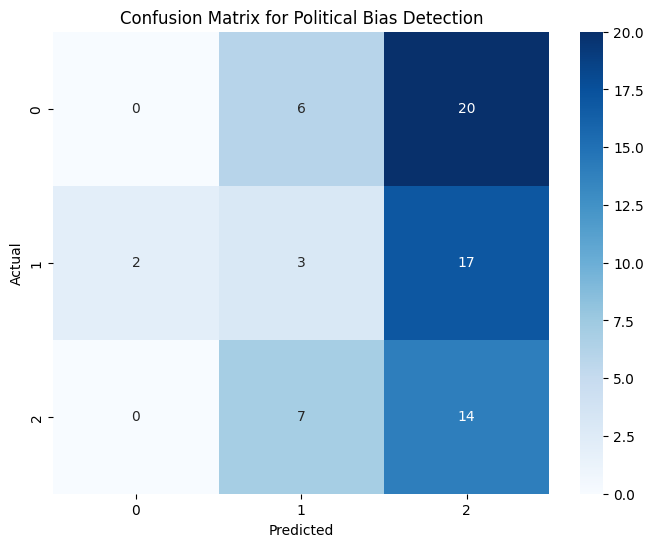

In [18]:

# Political Bias Detection (example with dummy labels)
bias_labels = [0, 1, 2] * ((len(df) // 3) + 1)
df['political_bias'] = bias_labels[:len(df)]

label_encoder = LabelEncoder()
df['bias_encoded'] = label_encoder.fit_transform(df['political_bias'])

X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['bias_encoded'], test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str)))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Political Bias Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## Step 7: Visualization of Sentiment and Emotional Analysis

Finally, we visualize the sentiment distribution and emotional analysis results using bar charts. This helps in better 
understanding the patterns in the scraped articles.


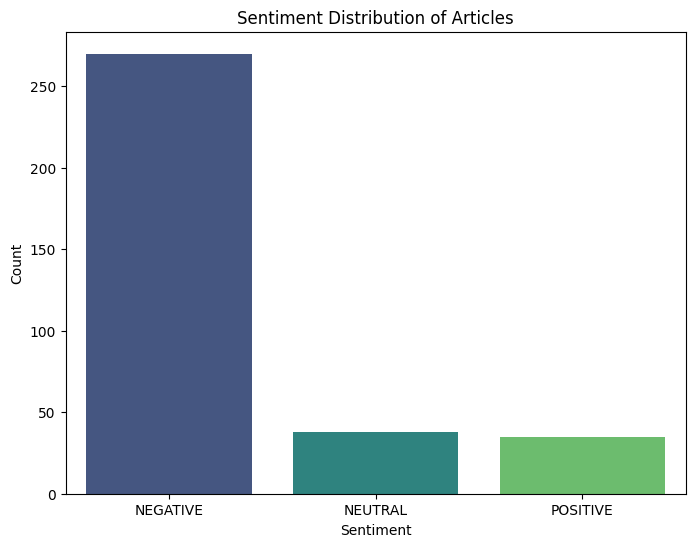

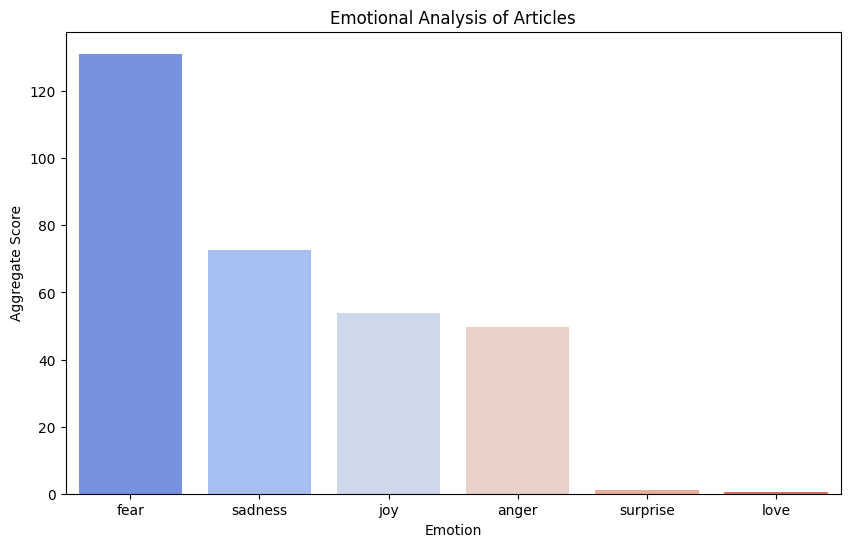

                                               title sentiment  \
0                BBC Sounds - Music. Radio. Podcasts  NEGATIVE   
1                                        BBC Weather  NEGATIVE   
2                                    BBC Newsletters   NEUTRAL   
3  Breaking News, World News, US News, Sports, Bu...  NEGATIVE   
4                BBC Sounds - Music. Radio. Podcasts  NEGATIVE   

   political_bias       joy       joy       joy       joy       joy       joy  \
0               0  0.986174  0.986174  0.986174  0.986174  0.986174  0.986174   
1               1  0.588855  0.588855  0.588855  0.588855  0.588855  0.588855   
2               2       NaN       NaN       NaN       NaN       NaN       NaN   
3               0  0.003773  0.003773  0.003773  0.003773  0.003773  0.003773   
4               1  0.986174  0.986174  0.986174  0.986174  0.986174  0.986174   

      anger  ...      love      love      love      love  surprise  surprise  \
0  0.005518  ...  0.000861  0.000861

In [19]:

# Visualize Sentiment Distribution
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution of Articles')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Visualize Emotional Analysis
emotions_agg = emotions_df.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=emotions_agg.index, y=emotions_agg.values, palette='coolwarm')
plt.title('Emotional Analysis of Articles')
plt.xlabel('Emotion')
plt.ylabel('Aggregate Score')
plt.show()

print(df[['title', 'sentiment', 'political_bias'] + list(emotions_df.columns)].head())